In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error
shap.initjs()
import json
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
from PyPDF2 import PdfReader
import re 
import csv
from rapidfuzz import process, fuzz
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


## Definire la directory per i file di output

In [154]:
# 1. Definisci la directory una sola volta
OUTPUT_DIR = r"C:/Users/Maria Beatrice/Desktop/test/UNIVERSITA/SECONDO anno magistrale/BIGDATA/Big-Data-Analytics/Progetto Big Data/output/preclinica"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 2. Funzione helper per creare il path completo
def file_path(filename):
    return os.path.join(OUTPUT_DIR, filename)

## Con questo codice si trasferisce il da file pdf a csv il file di domande di nostro interesse per gli anni 2016, 2017, 2018, 2019



## Area preclinca 2016 

In [155]:
# Per prima cosa si importa il file pdf e si estrae il testo da ogni pagina.

pdf_path = "Area_Pre_Clinica_2016.pdf"
reader = PdfReader(pdf_path)

full_text = ""
for page in reader.pages:
    full_text += page.extract_text() + "\n"


### Si definisce il pattern con cui trovare le domande, le opzioni e segnare la risposta corretta

In [157]:
question_pattern = re.compile(
    r"(?P<id>\d{1,4})\.\s+(?P<question>.+?)\n"                       # ID e testo domanda
    r"^\s*A(?P<correct_a>\*)?\s+(?P<A>.+?)\n"                        # Risposta A
    r"^\s*B(?P<correct_b>\*)?\s+(?P<B>.+?)\n"                        # Risposta B
    r"^\s*C(?P<correct_c>\*)?\s+(?P<C>.+?)\n"                        # Risposta C
    r"^\s*D(?P<correct_d>\*)?\s+(?P<D>.+?)\n"                        # Risposta D
    r"^\s*E(?P<correct_e>\*)?\s+(?P<E>.+?)(?=\n\d+\.\s|\Z)",         # Risposta E e fine
    re.DOTALL | re.MULTILINE
)


### Condizioni per memorizzare le macro categorie in base al codice della domanda

In [158]:
# Si crea una lista per memorizzare le domande e le risposte estratte.
def macro_category_from_id(qid: int) -> str:
    if 1 <= qid <= 395:
        return "farmacologia"
    elif 396 <= qid <= 1564:
        return "fisiologia"
    elif 1565 <= qid <= 1907:
        return "morfologia"
    elif 1908 <= qid <= 2822:
        return "patologia"
    elif 2823 <= qid <= 3344:
        return "prevenzione e deontologia medica"
    else:
        return ""


In [159]:
# Si esegue la ricerca delle domande nel testo completo utilizzando la regex definita.
questions = []
for match in question_pattern.finditer(full_text):
    qid = int(match.group("id"))
    correct = ""
    for letter in "abcde":
        if match.group(f"correct_{letter}"):
            correct = letter.upper()
            break

    questions.append({
        "id": qid,
        "question": match.group("question").strip().replace("\n", " "),
        "A": match.group("A").strip().replace("\n", " "),
        "B": match.group("B").strip().replace("\n", " "),
        "C": match.group("C").strip().replace("\n", " "),
        "D": match.group("D").strip().replace("\n", " "),
        "E": match.group("E").strip().replace("\n", " "),
        "answer": correct,
        "category": "Area Preclinica 2016",
        "macro category": macro_category_from_id(qid)
    })


In [160]:
#  
with open("area_preclinica_2016_domande.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=questions[0].keys())
    writer.writeheader()
    writer.writerows(questions)


In [161]:
df_2016_preclinica = pd.read_csv('area_preclinica_2016_domande.csv')
df_2016_preclinica.iloc[1551]

id                                                             1552
question                            Il gozzo sporadico e' dovuto a:
A                 difetti nei recettori periferici per gli ormon...
B                    difetti nella biosintesi degli ormoni tiroidei
C                      accelerato catabolismo degli ormoni tiroidei
D                 asportazione chirurgica di una parte della tir...
E                       asportazione chirurgica di tutta la tiroide
answer                                                            B
category                                       Area Preclinica 2016
macro category                                           fisiologia
Name: 1551, dtype: object

In [162]:
### SI pulisce il testo dagli errori: per esempio nelle domande a pie pagina viene inglobato il testo Area Cinica Ministero dell'istruzione..., si rendono tutti i testi minuscoli e si tolgono i doppi spazi

In [163]:
# puliamo il testo dagli errori
df = df_2016_preclinica
regex_da_rimuovere = r"AREA PRE-CLINICA Pag\.\s*\d+\/\d+\s*Ministero dell Istruzione, dell\s*Università e della Ricerca,\s*,"
regex_da_rimuovere2=r"AREA PRE-CLINICA Pag\.\s*\d+/\d*"
for column in df[["question", "A", "B", "C", "D", "E", "answer"]]:
     df[column] = df[column].str.replace(regex_da_rimuovere, '', regex=True, flags=re.IGNORECASE) # Rimuovi la regex
     df[column]=df[column].str.replace(regex_da_rimuovere2, '', regex=True, flags=re.IGNORECASE) 
     df[column] = df[column].str.strip() # Rimuovi spazi iniziali e finali
     df[column] = df[column].str.replace(r'\s+', ' ', regex=True) # Rimuovi spazi multipli
     if column in ["question", "A", "B", "C", "D", "E"]:
          df[column]=df[column].str.lower()
     


In [164]:
df.to_csv(file_path("area_preclinica_2016_domande_pulite.csv"), encoding='utf-8')
#pd.read_csv(file_path("area_clinica_2016_domande_pulite.csv")).iloc[1551]

In [165]:
#Si fa un check per verificare che tutte le domande siano state registrate nel File

inconsistenti = df_2016_preclinica[df_2016_preclinica.index != df_2016_preclinica["id"] - 1]

# Mostra o salva le righe inconsistenti
print(inconsistenti)
#non ci sono osservazioni inconsistenti

Empty DataFrame
Columns: [id, question, A, B, C, D, E, answer, category, macro category]
Index: []


Si fa un check delle domande e delle risposte tra il full text e il il csv ottenuto

In [113]:
# Confrontiamo automaticamente le prime 20 domande tra PDF (testo estratto) e CSV

# Estrarre le domande dal CSV
df_sample = df_2016_preclinica.copy()

# Estrarre lo stesso testo dal PDF già precedentemente letto
# Spezziamo le domande dal testo intero PDF (già caricato in `full_text`)
pdf_questions_raw = question_pattern.findall(full_text)

# Mappiamo l'output del PDF in un dizionario per confronto
pdf_data_map = {}
for q in pdf_questions_raw:
    qid = int(q[0])
    pdf_data_map[qid] = {
        "question": q[1].strip().replace("\n", " "),
        "A": q[3].strip().replace("\n", " "),
        "B": q[5].strip().replace("\n", " "),
        "C": q[7].strip().replace("\n", " "),
        "D": q[9].strip().replace("\n", " "),
        "E": q[11].strip().replace("\n", " "),
    }

# Confronta le prime 20 domande
differenze = []
for _, row in df_sample.iterrows():
    qid = row["id"]
    pdf_entry = pdf_data_map.get(qid)
    if not pdf_entry:
        continue

    diffs = {}
    for key in ["question", "A", "B", "C", "D", "E",]:
        csv_text = str(row[key]).strip()
        pdf_text = str(pdf_entry[key]).strip()
        if csv_text != pdf_text:
            diffs[key] = {"csv": csv_text, "pdf": pdf_text}
    
    if diffs:
        differenze.append({"id": qid, "diffs": diffs})

# Mostriamo le differenze trovate
differenze


[{'id': 1,
  'diffs': {'question': {'csv': "in una polmonite da staphylococcus aureus meticillino-resistente l'antibiotico di scelta è:",
    'pdf': "In una polmonite da Staphylococcus aureus meticillino-resistente l'antibiotico di scelta è:"}}},
 {'id': 2,
  'diffs': {'question': {'csv': 'i farmaci ipoglicemizzanti orali della classe delle sulfaniluree:',
    'pdf': 'I farmaci ipoglicemizzanti orali della classe delle sulfaniluree:'},
   'C': {'csv': 'sono indicati nel diabete giovanile (tipo i)',
    'pdf': 'sono indicati nel diabete giovanile (tipo I)'}}},
 {'id': 3,
  'diffs': {'question': {'csv': 'quale tra i seguenti farmaci antidiabetici, determina ipoglicemia indirettamente?',
    'pdf': 'Quale tra i seguenti farmaci antidiabetici, determina ipoglicemia indirettamente?'},
   'E': {'csv': 'insulina lantus', 'pdf': 'Insulina Lantus'}}},
 {'id': 4,
  'diffs': {'question': {'csv': "nello shock emorragico il trattamento iniziale consiste nell'infusione di:",
    'pdf': "Nello shock 

Si verifica che le categorie siano corrette e le risposte

In [166]:
df.info()
fil=df["answer"].isna()==True
df[fil]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3344 entries, 0 to 3343
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3344 non-null   int64 
 1   question        3344 non-null   object
 2   A               3344 non-null   object
 3   B               3344 non-null   object
 4   C               3344 non-null   object
 5   D               3344 non-null   object
 6   E               3344 non-null   object
 7   answer          3344 non-null   object
 8   category        3344 non-null   object
 9   macro category  3344 non-null   object
dtypes: int64(1), object(9)
memory usage: 261.4+ KB


,id,question,A,B,C,D,E,answer,category,macro category


## Area preclinica 2017 

In [167]:
# Per prima cosa si importa il file pdf e si estrae il testo da ogni pagina.

pdf_path = "Area_Pre_Clinica_2017.pdf"
reader = PdfReader(pdf_path)

full_text = ""
for page in reader.pages:
    full_text += page.extract_text() + "\n"

In [168]:
question_pattern = re.compile(
    r"(?P<id>\d{1,4})\.\s+(?P<question>.+?)\n"                       # ID e testo domanda
    r"^\s*A(?P<correct_a>\*)?\s+(?P<A>.+?)\n"                        # Risposta A
    r"^\s*B(?P<correct_b>\*)?\s+(?P<B>.+?)\n"                        # Risposta B
    r"^\s*C(?P<correct_c>\*)?\s+(?P<C>.+?)\n"                        # Risposta C
    r"^\s*D(?P<correct_d>\*)?\s+(?P<D>.+?)\n"                        # Risposta D
    r"^\s*E(?P<correct_e>\*)?\s+(?P<E>.+?)(?=\n\d+\.\s|\Z)",         # Risposta E e fine
    re.DOTALL | re.MULTILINE
)

In [169]:
# Si crea una lista per memorizzare le domande e le risposte estratte.
def macro_category_from_id(qid: int) -> str:
    if 1 <= qid <= 393:
        return "farmacologia"
    elif 394 <= qid <= 1555:
        return "fisiologia"
    elif 1556 <= qid <= 1897:
        return "morfologia"
    elif 1898 <= qid <= 2805:
        return "patologia"
    elif 2806 <= qid <= 3324:
        return "prevenzione e deontologia medica"
    else:
        return ""


In [170]:
# Si esegue la ricerca delle domande nel testo completo utilizzando la regex definita.
questions = []
for match in question_pattern.finditer(full_text):
    qid = int(match.group("id"))
    correct = ""
    for letter in "abcde":
        if match.group(f"correct_{letter}"):
            correct = letter.upper()
            break

    questions.append({
        "id": qid,
        "question": match.group("question").strip().replace("\n", " "),
        "A": match.group("A").strip().replace("\n", " "),
        "B": match.group("B").strip().replace("\n", " "),
        "C": match.group("C").strip().replace("\n", " "),
        "D": match.group("D").strip().replace("\n", " "),
        "E": match.group("E").strip().replace("\n", " "),
        "answer": correct,
        "category": "Area Preclinica 2017",
        "macro category": macro_category_from_id(qid)
    })


In [171]:
#  
with open("area_preclinica_2017_domande.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=questions[0].keys())
    writer.writeheader()
    writer.writerows(questions)


In [120]:
df_2017_preclinica = pd.read_csv('area_preclinica_2017_domande.csv')
df_2017_preclinica.head(-10)
#len(df_2017_preclinica)

,id,question,A,B,C,D,E,answer,category,macro category
0,1,In una polmonite da Staphylococcus aureus meti...,vancomicina,oxacillina,gentamicina,piperacillina,claritromicina,A,Area Preclinica 2017,farmacologia
1,2,I farmaci ipoglicemizzanti orali della classe ...,sono sempre impiegati in monoterapia,stimolano la secrezione di insulina e possono ...,sono indicati nel diabete giovanile (tipo I),"a differenza delle biguanidi, non necessitano ...",possono antagonizzare l'effetto ipoglicemizzan...,B,Area Preclinica 2017,farmacologia
2,3,"Quale tra i seguenti farmaci antidiabetici, de...",glipizide,clorpropamide,tolbutamide,metformina,Insulina Lantus,D,Area Preclinica 2017,farmacologia
3,4,Nello shock emorragico il trattamento iniziale...,cristalloidi,colloidi non proteici,albumina,mannitolo,protamina solfato,A,Area Preclinica 2017,farmacologia
4,5,Indicare quale dei seguenti farmaci antitumora...,cisplatino,metotressato,5-fluorouracile,citarabina,6-mercaptopurina,A,Area Preclinica 2017,farmacologia
...,...,...,...,...,...,...,...,...,...,...
3309,3310,Non è un inquinante atmosferico irritante per ...,O3,NO2,SO2,CO,H2SO4,D,Area Preclinica 2017,prevenzione e deontologia medica
3310,3311,"La prima causa di morte nel sesso femminile, i...",Incidenti stradali,Tumore al seno,Tumore al polmone,Malattie dell'apparato respiratorio,Malattie cardiovascolari,E,Area Preclinica 2017,prevenzione e deontologia medica
3311,3312,Per prevenire le infezioni trasmesse dagli ali...,acquistare piatti pronti,consumare solo alimenti che hanno un bell'aspetto,consumare solo alimenti cotti,cuocere bene i cibi in modo che tutte le parti...,conservare a temperatura ambiente gli alimenti...,D,Area Preclinica 2017,prevenzione e deontologia medica
3312,3313,La disinfestazione integrale di locali chiusi ...,Aldeide formica,Esteri organofosforici,Anidride solforosa,Carbammati,Clorurati organici,C,Area Preclinica 2017,prevenzione e deontologia medica


In [172]:
# puliamo il testo dagli errori
#df_2016_preclinica.info()
df = df_2017_preclinica
regex_da_rimuovere = r"AREA PRE-CLINICA Pag\.\s*\d+\/\d+\s*Ministero dell Istruzione, dell\s*Università e della Ricerca,\s*,"
regex_da_rimuovere2=r"AREA PRE-CLINICA Pag\.\s*\d+/\d*"
for column in df[["question", "A", "B", "C", "D", "E", "answer"]]:
     df[column] = df[column].str.replace(regex_da_rimuovere, '', regex=True, flags=re.IGNORECASE) # Rimuovi la regex
     df[column]=df[column].str.replace(regex_da_rimuovere2, '', regex=True, flags=re.IGNORECASE) 
     df[column] = df[column].str.strip() # Rimuovi spazi iniziali e finali
     df[column] = df[column].str.replace(r'\s+', ' ', regex=True) # Rimuovi spazi multipli
     if column in ["question", "A", "B", "C", "D", "E"]:
          df[column]=df[column].str.lower()

In [173]:
df.to_csv(file_path("area_preclinica_2017_domande_pulite.csv"), encoding='utf-8')

In [174]:
inconsistenti = df_2017_preclinica[df_2017_preclinica.index != df_2017_preclinica["id"] - 1]

# Mostra o salva le righe inconsistenti
print(inconsistenti)

Empty DataFrame
Columns: [id, question, A, B, C, D, E, answer, category, macro category]
Index: []


In [175]:
# Confrontiamo automaticamente le prime 20 domande tra PDF (testo estratto) e CSV

# Estrarre le domande dal CSV
df_sample = df_2017_preclinica.copy()

# Estrarre lo stesso testo dal PDF già precedentemente letto
# Spezziamo le domande dal testo intero PDF (già caricato in `full_text`)
pdf_questions_raw = question_pattern.findall(full_text)

# Mappiamo l'output del PDF in un dizionario per confronto
pdf_data_map = {}
for q in pdf_questions_raw:
    qid = int(q[0])
    pdf_data_map[qid] = {
        "question": q[1].strip().replace("\n", " "),
        "A": q[3].strip().replace("\n", " "),
        "B": q[5].strip().replace("\n", " "),
        "C": q[7].strip().replace("\n", " "),
        "D": q[9].strip().replace("\n", " "),
        "E": q[11].strip().replace("\n", " "),
    }

# Confronta le prime 20 domande
differenze = []
for _, row in df_sample.iterrows():
    qid = row["id"]
    pdf_entry = pdf_data_map.get(qid)
    if not pdf_entry:
        continue

    diffs = {}
    for key in ["question", "A", "B", "C", "D", "E",]:
        csv_text = str(row[key]).strip()
        pdf_text = str(pdf_entry[key]).strip()
        if csv_text != pdf_text:
            diffs[key] = {"csv": csv_text, "pdf": pdf_text}
    
    if diffs:
        differenze.append({"id": qid, "diffs": diffs})

# Mostriamo le differenze trovate
differenze


[{'id': 1,
  'diffs': {'question': {'csv': "in una polmonite da staphylococcus aureus meticillino-resistente l'antibiotico di scelta è:",
    'pdf': "In una polmonite da Staphylococcus aureus meticillino-resistente l'antibiotico di scelta è:"}}},
 {'id': 2,
  'diffs': {'question': {'csv': 'i farmaci ipoglicemizzanti orali della classe delle sulfaniluree:',
    'pdf': 'I farmaci ipoglicemizzanti orali della classe delle sulfaniluree:'},
   'C': {'csv': 'sono indicati nel diabete giovanile (tipo i)',
    'pdf': 'sono indicati nel diabete giovanile (tipo I)'}}},
 {'id': 3,
  'diffs': {'question': {'csv': 'quale tra i seguenti farmaci antidiabetici, determina ipoglicemia indirettamente?',
    'pdf': 'Quale tra i seguenti farmaci antidiabetici, determina ipoglicemia indirettamente?'},
   'E': {'csv': 'insulina lantus', 'pdf': 'Insulina Lantus'}}},
 {'id': 4,
  'diffs': {'question': {'csv': "nello shock emorragico il trattamento iniziale consiste nell'infusione di:",
    'pdf': "Nello shock 

## Proviamo a mergiare i due dataset per vedere quali domande sono in comune e quali no

In [176]:
#df_2016_preclinica.info()
#df_2016_preclinica.isna().sum()
df_2017_preclinica.info()
fil=df_2017_preclinica["answer"].isna()==True
df_2017_preclinica[fil]
#df_2017_preclinica["id"]==1258
#df_2017_preclinica[df_2017_preclinica["id"]==1250]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3324 entries, 0 to 3323
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3324 non-null   int64 
 1   question        3324 non-null   object
 2   A               3324 non-null   object
 3   B               3324 non-null   object
 4   C               3324 non-null   object
 5   D               3324 non-null   object
 6   E               3324 non-null   object
 7   answer          3324 non-null   object
 8   category        3324 non-null   object
 9   macro category  3324 non-null   object
dtypes: int64(1), object(9)
memory usage: 259.8+ KB


,id,question,A,B,C,D,E,answer,category,macro category


In [177]:

# Unisci i due DataFrame
df_merged = pd.concat([df_2016_preclinica,  df_2017_preclinica])
len(df_merged)

mask_diff = ~df_merged.duplicated(subset=["question", "A", "B", "C", "D", "E", "answer"], keep=False)
df_differenze = df_merged[mask_diff]

df_differenze.to_csv(file_path("differenze_area_preclinica_16_17.csv"), index=False, encoding='utf-8')


#Rimuovi i duplicati (tutte le colonne devono essere uguali)

df_merged_2016_2017_preclinica = df_merged.drop_duplicates(subset=["question", "A", "B", "C", "D", "E", "answer"])
len(df_merged_2016_2017_preclinica)

#fil=df_merged_2016_2017["question"]=="il mannitolo è usato come:"
#df_merged_2016_2017[df_merged_2016_2017["question"]=="tutte le seguenti affermazioni sull'epatite a sono esatte eccetto:"]

3380

## PreClinica 2018


In [179]:
# Per prima cosa si importa il file pdf e si estrae il testo da ogni pagina.

pdf_path = "Area_Pre_Clinica_2018.pdf"
reader = PdfReader(pdf_path)

full_text = ""
for page in reader.pages:
    full_text += page.extract_text() + "\n"

In [180]:
question_pattern = re.compile(
    r"(?P<id>\d{1,4})\.\s+(?P<question>.+?)\n"                       # ID e testo domanda
    r"^\s*A(?P<correct_a>\*)?\s+(?P<A>.+?)\n"                        # Risposta A
    r"^\s*B(?P<correct_b>\*)?\s+(?P<B>.+?)\n"                        # Risposta B
    r"^\s*C(?P<correct_c>\*)?\s+(?P<C>.+?)\n"                        # Risposta C
    r"^\s*D(?P<correct_d>\*)?\s+(?P<D>.+?)\n"                        # Risposta D
    r"^\s*E(?P<correct_e>\*)?\s+(?P<E>.+?)(?=\n\d+\.\s|\Z)",         # Risposta E e fine
    re.DOTALL | re.MULTILINE
)


In [181]:
# Si crea una lista per memorizzare le domande e le risposte estratte.
def macro_category_from_id(qid: int) -> str:
    if 1 <= qid <= 390:
        return "farmacologia"
    elif 391 <= qid <= 1547:
        return "fisiologia"
    elif 1548 <= qid <= 1888:
        return "morfologia"
    elif 1889 <= qid <= 2788:
        return "patologia"
    elif 2789 <= qid <= 3306:
        return "prevenzione e deontologia medica"
    else:
        return ""


In [182]:
# Si esegue la ricerca delle domande nel testo completo utilizzando la regex definita.
questions = []
for match in question_pattern.finditer(full_text):
    qid = int(match.group("id"))
    correct = ""
    for letter in "abcde":
        if match.group(f"correct_{letter}"):
            correct = letter.upper()
            break

    questions.append({
        "id": qid,
        "question": match.group("question").strip().replace("\n", " "),
        "A": match.group("A").strip().replace("\n", " "),
        "B": match.group("B").strip().replace("\n", " "),
        "C": match.group("C").strip().replace("\n", " "),
        "D": match.group("D").strip().replace("\n", " "),
        "E": match.group("E").strip().replace("\n", " "),
        "answer": correct,
        "category": "Area Preclinica 2018",
        "macro category": macro_category_from_id(qid)
    })


In [183]:
with open("area_preclinica_2018_domande.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=questions[0].keys())
    writer.writeheader()
    writer.writerows(questions)


In [184]:

df_2018_preclinica = pd.read_csv('area_preclinica_2018_domande.csv')
len(df_2018_preclinica)

3306

In [185]:
# puliamo il testo dagli errori
#df_2016_preclinica.info()
df = df_2018_preclinica
regex_da_rimuovere = r"AREA PRE-CLINICA Pag\.\s*\d+\/\d+\s*Ministero dell Istruzione, dell\s*Università e della Ricerca,\s*,"
regex_da_rimuovere2=r"AREA PRE-CLINICA Pag\.\s*\d+/\d*"
for column in df[["question", "A", "B", "C", "D", "E", "answer"]]:
     df[column] = df[column].str.replace(regex_da_rimuovere, '', regex=True, flags=re.IGNORECASE) # Rimuovi la regex
     df[column]=df[column].str.replace(regex_da_rimuovere2, '', regex=True, flags=re.IGNORECASE) 
     df[column] = df[column].str.strip() # Rimuovi spazi iniziali e finali
     df[column] = df[column].str.replace(r'\s+', ' ', regex=True) # Rimuovi spazi multipli
     if column in ["question", "A", "B", "C", "D", "E"]:
          df[column]=df[column].str.lower()

In [186]:
df_2018_preclinica.to_csv(file_path("area_preclinica_2018_domande_pulite.csv"), encoding='utf-8')
df_2018_preclinica.info()
fil=df_2018_preclinica["answer"].isna()==True
df_2018_preclinica[fil]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3306 entries, 0 to 3305
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3306 non-null   int64 
 1   question        3306 non-null   object
 2   A               3306 non-null   object
 3   B               3306 non-null   object
 4   C               3306 non-null   object
 5   D               3306 non-null   object
 6   E               3306 non-null   object
 7   answer          3306 non-null   object
 8   category        3306 non-null   object
 9   macro category  3306 non-null   object
dtypes: int64(1), object(9)
memory usage: 258.4+ KB


,id,question,A,B,C,D,E,answer,category,macro category


In [187]:
df_merged = pd.concat([df_merged_2016_2017_preclinica,  df_2018_preclinica])
#len(df_merged)

mask_diff = ~df_merged.duplicated(subset=["question", "A", "B", "C", "D", "E", "answer"], keep=False)
df_differenze = df_merged[mask_diff]
len(df_differenze)


df_differenze.to_csv(file_path("differenze_area_preclinica_16_18.csv"), index=False, encoding='utf-8')


#Rimuovi i duplicati (tutte le colonne devono essere uguali)

df_merged_2016_2018_preclinica = df_merged.drop_duplicates(subset=["question", "A", "B", "C", "D", "E", "answer"])
len(df_merged_2016_2018_preclinica)

3387

## PreClinica 2019

In [188]:
# Per prima cosa si importa il file pdf e si estrae il testo da ogni pagina.

pdf_path = "Area_Pre_Clinica_2019.pdf"
reader = PdfReader(pdf_path)

full_text = ""
for page in reader.pages:
    full_text += page.extract_text() + "\n"

In [137]:
question_pattern = re.compile(
    r"(?P<id>\d{1,4})\.\s+(?P<question>.+?)\n"                       # ID e testo domanda
    r"^\s*A(?P<correct_a>\*)?\s+(?P<A>.+?)\n"                        # Risposta A
    r"^\s*B(?P<correct_b>\*)?\s+(?P<B>.+?)\n"                        # Risposta B
    r"^\s*C(?P<correct_c>\*)?\s+(?P<C>.+?)\n"                        # Risposta C
    r"^\s*D(?P<correct_d>\*)?\s+(?P<D>.+?)\n"                        # Risposta D
    r"^\s*E(?P<correct_e>\*)?\s+(?P<E>.+?)(?=\n\d+\.\s|\Z)",         # Risposta E e fine
    re.DOTALL | re.MULTILINE
)


In [189]:
# Si crea una lista per memorizzare le domande e le risposte estratte.
def macro_category_from_id(qid: int) -> str:
    if 1 <= qid <= 390:
        return "farmacologia"
    elif 391 <= qid <= 1547:
        return "fisiologia"
    elif 1548 <= qid <= 1888:
        return "morfologia"
    elif 1889 <= qid <= 2788:
        return "patologia"
    elif 2789 <= qid <= 3306:
        return "prevenzione e deontologia medica"
    else:
        return ""

In [190]:
# Si esegue la ricerca delle domande nel testo completo utilizzando la regex definita.
questions = []
for match in question_pattern.finditer(full_text):
    qid = int(match.group("id"))
    correct = ""
    for letter in "abcde":
        if match.group(f"correct_{letter}"):
            correct = letter.upper()
            break

    questions.append({
        "id": qid,
        "question": match.group("question").strip().replace("\n", " "),
        "A": match.group("A").strip().replace("\n", " "),
        "B": match.group("B").strip().replace("\n", " "),
        "C": match.group("C").strip().replace("\n", " "),
        "D": match.group("D").strip().replace("\n", " "),
        "E": match.group("E").strip().replace("\n", " "),
        "answer": correct,
        "category": "Area Preclinica 2019",
        "macro category": macro_category_from_id(qid)
    })

In [191]:
with open("area_preclinica_2019_domande.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=questions[0].keys())
    writer.writeheader()
    writer.writerows(questions)

In [141]:
df_2019_preclinica = pd.read_csv('area_preclinica_2019_domande.csv')
df_2019_preclinica.head(-10)


,id,question,A,B,C,D,E,answer,category,macro category
0,1,In una polmonite da Staphylococcus aureus meti...,vancomicina,oxacillina,gentamicina,piperacillina,claritromicina,A,Area Preclinica 2019,farmacologia
1,2,I farmaci ipoglicemizzanti orali della classe ...,sono sempre impiegati in monoterapia,stimolano la secrezione di insulina e possono ...,sono indicati nel diabete giovanile (tipo I),"a differenza delle biguanidi, non necessitano ...",possono antagonizzare l'effetto ipoglicemizzan...,B,Area Preclinica 2019,farmacologia
2,3,"Quale tra i seguenti farmaci antidiabetici, de...",glipizide,clorpropamide,tolbutamide,metformina,Insulina Lantus,D,Area Preclinica 2019,farmacologia
3,4,Nello shock emorragico il trattamento iniziale...,cristalloidi,colloidi non proteici,albumina,mannitolo,protamina solfato,A,Area Preclinica 2019,farmacologia
4,5,Indicare quale dei seguenti farmaci antitumora...,cisplatino,metotressato,5-fluorouracile,citarabina,6-mercaptopurina,A,Area Preclinica 2019,farmacologia
...,...,...,...,...,...,...,...,...,...,...
3291,3292,Non è un inquinante atmosferico irritante per ...,O3,NO2,SO2,CO,H2SO4,D,Area Preclinica 2019,prevenzione e deontologia medica
3292,3293,"La prima causa di morte nel sesso femminile, i...",Incidenti stradali,Tumore al seno,Tumore al polmone,Malattie dell'apparato respiratorio,Malattie cardiovascolari,E,Area Preclinica 2019,prevenzione e deontologia medica
3293,3294,Per prevenire le infezioni trasmesse dagli ali...,acquistare piatti pronti,consumare solo alimenti che hanno un bell'aspetto,consumare solo alimenti cotti,cuocere bene i cibi in modo che tutte le parti...,conservare a temperatura ambiente gli alimenti...,D,Area Preclinica 2019,prevenzione e deontologia medica
3294,3295,La disinfestazione integrale di locali chiusi ...,Aldeide formica,Esteri organofosforici,Anidride solforosa,Carbammati,Clorurati organici,C,Area Preclinica 2019,prevenzione e deontologia medica


In [192]:
# puliamo il testo dagli errori
#df_2016_preclinica.info()
df = df_2019_preclinica
regex_da_rimuovere = r"AREA PRE-CLINICA Pag\.\s*\d+\/\d+\s*Ministero dell Istruzione, dell\s*Università e della Ricerca,\s*,"
regex_da_rimuovere2=r"AREA PRE-CLINICA Pag\.\s*\d+/\d*"
for column in df[["question", "A", "B", "C", "D", "E", "answer"]]:
     df[column] = df[column].str.replace(regex_da_rimuovere, '', regex=True, flags=re.IGNORECASE) # Rimuovi la regex
     df[column]=df[column].str.replace(regex_da_rimuovere2, '', regex=True, flags=re.IGNORECASE) 
     df[column] = df[column].str.strip() # Rimuovi spazi iniziali e finali
     df[column] = df[column].str.replace(r'\s+', ' ', regex=True) # Rimuovi spazi multipli
     if column in ["question", "A", "B", "C", "D", "E"]:
          df[column]=df[column].str.lower()

In [193]:
df.to_csv(file_path("area_preclinica_2019_domande_pulite.csv"), encoding='utf-8')

## Mrgiamo il dataset 2016_2018 con 2019

In [195]:
df_merged = pd.concat([df_merged_2016_2018_preclinica, df_2019_preclinica])
len(df_merged)

mask_diff = ~df_merged.duplicated(subset=["question", "A", "B", "C", "D", "E", "answer"], keep=False)
df_differenze = df_merged[mask_diff]
len(df_differenze)


df_differenze.to_csv(file_path("differenze_area_preclinica_16_19.csv"), index=False, encoding='utf-8')


#Rimuovi i duplicati (tutte le colonne devono essere uguali)

df_merged_2016_2019_preclinica = df_merged.drop_duplicates(subset=["question", "A", "B", "C", "D", "E", "answer"])
df_merged_2016_2019_preclinica.head()
#len(df_merged_2016_2019_preclinica)


,id,question,A,B,C,D,E,answer,category,macro category
0,1,in una polmonite da staphylococcus aureus meti...,vancomicina,oxacillina,gentamicina,piperacillina,claritromicina,A,Area Preclinica 2016,farmacologia
1,2,i farmaci ipoglicemizzanti orali della classe ...,sono sempre impiegati in monoterapia,stimolano la secrezione di insulina e possono ...,sono indicati nel diabete giovanile (tipo i),"a differenza delle biguanidi, non necessitano ...",possono antagonizzare l'effetto ipoglicemizzan...,B,Area Preclinica 2016,farmacologia
2,3,"quale tra i seguenti farmaci antidiabetici, de...",glipizide,clorpropamide,tolbutamide,metformina,insulina lantus,D,Area Preclinica 2016,farmacologia
3,4,nello shock emorragico il trattamento iniziale...,cristalloidi,colloidi non proteici,albumina,mannitolo,protamina solfato,A,Area Preclinica 2016,farmacologia
4,5,indicare quale dei seguenti farmaci antitumora...,cisplatino,metotressato,5-fluorouracile,citarabina,6-mercaptopurina,A,Area Preclinica 2016,farmacologia


## Troviamo le frasi piu simili per capire se effettivamente le domande sono diverse

In [196]:
# ci sono testi che differiscono di pochissimo, magari per errori di battitura, ma bisogna verificare cche siano diversi.
#utilizziamo fuz

df1 =df_merged_2016_2019_preclinica.copy() 
df1["concatenated"] = df1["question"] + " " + df1["A"] + " " + df1["B"] + " " + df1["C"] + " " + df1["D"] + " " + df1["E"]

# 3. Calcolo TF-IDF
with open("stopwords-it.txt", encoding="utf-8") as f:
    italian_stopwords = f.read().splitlines()

vectorizer = TfidfVectorizer(stop_words=italian_stopwords)
tfidf_matrix = vectorizer.fit_transform(df1["concatenated"])

# 4. Calcolo della similarità del coseno
cosine_sim = cosine_similarity(tfidf_matrix)

# 5. Estrai coppie con similarità elevata (sopra 0.9)
soglia = 0.98
similar_pairs = []

for i in range(len(df1)):
    for j in range(i + 1, len(df1)):
        score = cosine_sim[i, j]
        if score >= soglia:
            similar_pairs.append({
                "id1": df1.iloc[i]["id"],
                "id2": df1.iloc[j]["id"],
                "category1":df1.iloc[i]["category"],
                "category2":df1.iloc[j]["category"],
                "c1": df1.iloc[i]["concatenated"],
                "c2": df1.iloc[j]["concatenated"],
                "question1": df1.iloc[i]["question"],
                "question2": df1.iloc[j]["question"],
                "similarity": score
            })

# 6. Risultato in DataFrame
similar_df = pd.DataFrame(similar_pairs).sort_values(by="similarity", ascending=False)

# 7. (Opzionale) Salva su CSV
similar_df.to_csv(file_path("domande_simili_tfidf.csv"), index=False)




In [197]:
len(similar_df)

48

In [200]:
#ora decido di salvare la primo occorrenza di ogni domanda doppiata
# 1. Ottieni la lista delle domande da rimuovere (prima occorrenza)
df=df_merged_2016_2019_preclinica
q_da_rimuovere = set(similar_df["question1"])

# 2. Filtra il DataFrame originale tenendo solo le righe il cui question non è nella lista da rimuovere, reimposto anche l'indice da 0 a n
df_filtrato = df[~df["question"].isin(q_da_rimuovere)]
len(df_filtrato)

#inseriamo una nuova id nel dataset di interesse
df_filtrato.insert(0, "new_id", range(1, len(df_filtrato) + 1))

df_filtrato["category"]


#df_filtrato.to_csv(file_path("area_preclinica_2016_2019_finale.csv"), index=False, encoding='utf-8')

0       Area Preclinica 2016
1       Area Preclinica 2016
2       Area Preclinica 2016
3       Area Preclinica 2016
4       Area Preclinica 2016
                ...         
2141    Area Preclinica 2019
2189    Area Preclinica 2019
2420    Area Preclinica 2019
2613    Area Preclinica 2019
2690    Area Preclinica 2019
Name: category, Length: 3341, dtype: object

In [201]:

# Carica il CSV per creare jsonl
df = pd.read_csv(file_path("area_preclinica_2016_2019_finale.csv"))  # <-- metti il nome del tuo file CSV

# Percorso di output
output_file = file_path("area_preclinica_2016_2019_finale.jsonl")

# Apri file in scrittura
with open(output_file, "w", encoding="utf-8") as f:
    for _, row in df.iterrows():
        # Costruisci dizionario nel formato richiesto
        json_obj = {
            "question": row["question"],
            "options": [
                {"A": row["A"]},
                {"B": row["B"]},
                {"C": row["C"]},
                {"D": row["D"]},
                {"E": row["E"]}
            ],
            "answer": row["answer"],
            "category": row["macro category"] ,
            "macro_category": row["category"]
        }
        # Scrivi ogni riga come JSON
        f.write(json.dumps(json_obj, ensure_ascii=False) + "\n")


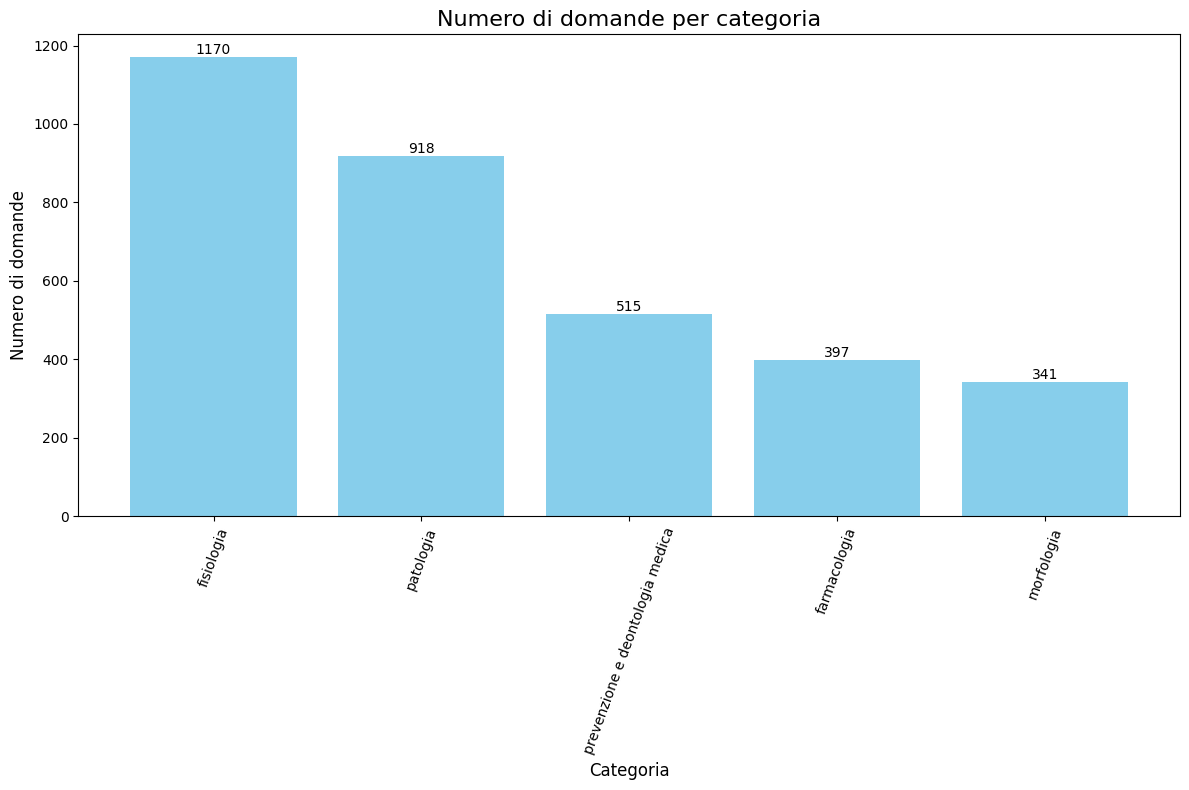

In [202]:

# Conta le domande per categoria
conteggio = df_filtrato['macro category'].value_counts()

# Imposta dimensioni della figura (larghezza, altezza in pollici)
plt.figure(figsize=(12, 8))  # aumenta queste per barre più spesse e alte

# Crea il grafico a barre con barre più larghe
ax = conteggio.plot(kind='bar', color='skyblue', width=0.8)

# Crea il grafico a barre con barre più larghe
conteggio.plot(kind='bar', color='skyblue', width=0.8)  # width=1.0 è il massimo

# Aggiungi titolo e label
plt.title('Numero di domande per categoria', fontsize=16)
plt.xlabel('Categoria', fontsize=12)
plt.ylabel('Numero di domande', fontsize=12)

# Aggiungi il numero sopra ogni colonna
for i, value in enumerate(conteggio):
    ax.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=70)
plt.tight_layout()
plt.show()



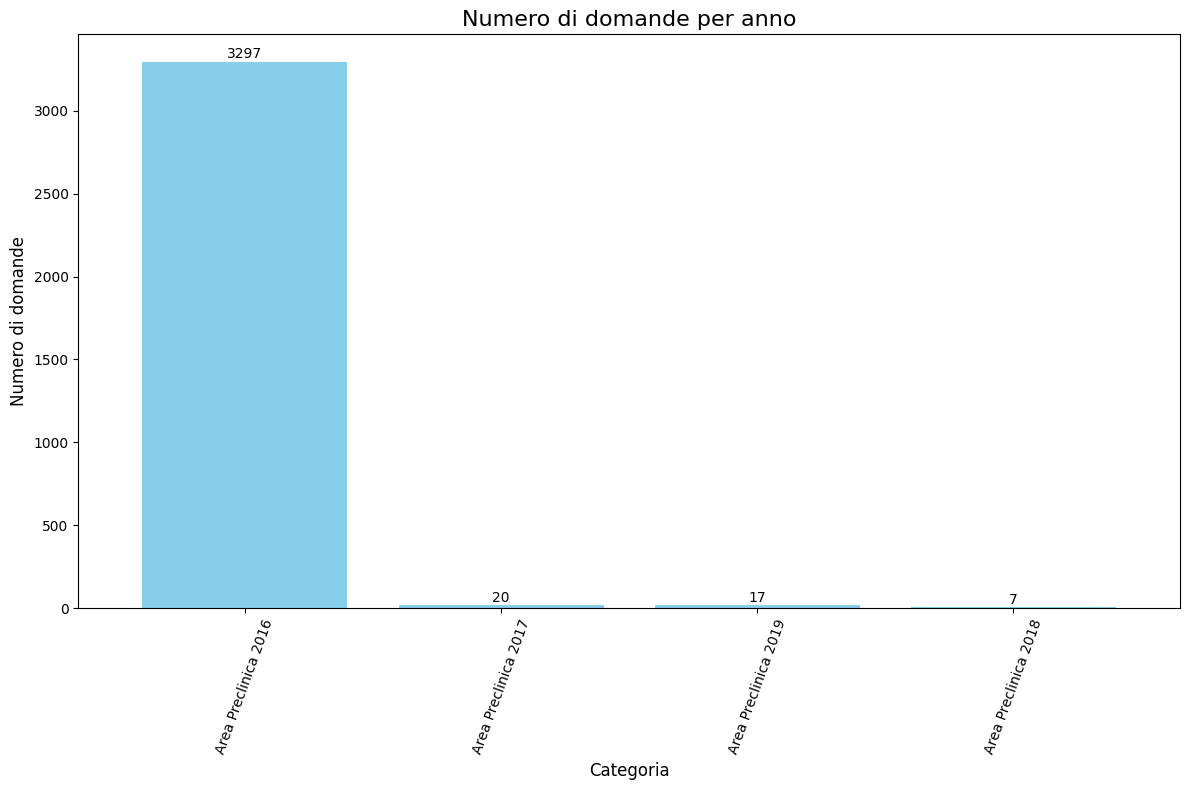

In [203]:
# Conta le domande per categoria
conteggio = df_filtrato['category'].value_counts()

# Imposta dimensioni della figura (larghezza, altezza in pollici)
plt.figure(figsize=(12, 8))

# Crea il grafico a barre con barre più larghe
ax = conteggio.plot(kind='bar', color='skyblue', width=0.8)

# Aggiungi titolo e label
plt.title('Numero di domande per anno', fontsize=16)
plt.xlabel('Categoria', fontsize=12)
plt.ylabel('Numero di domande', fontsize=12)
plt.xticks(rotation=70)

# Aggiungi il numero sopra ogni colonna
for i, value in enumerate(conteggio):
    ax.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### File completo con tutte le domande

In [212]:
df_preclinica = pd.read_csv(file_path("area_preclinica_2016_2019_finale.csv"))

# Usa il percorso assoluto per il file clinica
CLINICA_PATH = r"C:/Users/Maria Beatrice/Desktop/test/UNIVERSITA/SECONDO anno magistrale/BIGDATA/Big-Data-Analytics/Progetto Big Data/output/clinica/area_clinica_2016_2019_finale.csv"
df_clinica = pd.read_csv(CLINICA_PATH)

df_finale = pd.concat([df_preclinica, df_clinica])
df_finale.to_csv("area_preclinica_clinica_2016_2019_finale.csv", index=False, encoding='utf-8')

# passaggio a jsonl
output_file = "area_preclinica_clinica_2016_2019_finale.jsonl"

# Apri file in scrittura
with open(output_file, "w", encoding="utf-8") as f:
    for _, row in df_finale .iterrows():
        # Costruisci dizionario nel formato richiesto
        json_obj = {
            "question": row["question"],
            "options": [
                {"A": row["A"]},
                {"B": row["B"]},
                {"C": row["C"]},
                {"D": row["D"]},
                {"E": row["E"]}
            ],
            "answer": row["answer"],
            "category": row["macro category"] ,
            "macro_category": row["category"]
        }
        # Scrivi ogni riga come JSON
        f.write(json.dumps(json_obj, ensure_ascii=False) + "\n")
